##Introduction
The dataset provides information about school announcements made by staff and faculty members. Columns such as title, body, signature, submission time, and category are included. The information appears to be used for assessing the various types of announcements issued as well as the frequency with which they occur.

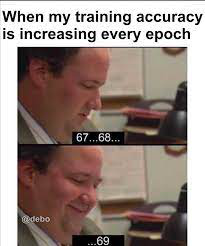

In [71]:
from PIL import Image
image = Image.open("/content/Accuracy.jpeg")
image.show()

In [1]:
import pandas as pd 
import nltk
nltk.download('words')
from nltk.corpus import words
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import re

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


#EDA

In [4]:

data = pd.read_csv('https://github.com/msaricaumbc/DS_data/blob/master/ds602/dataset_newsletter.csv?raw=true')

In [5]:

data.head()

,Unnamed: 0,title,body,signature,submissiontime,category
0,0,Mrs. Laurence Class,"Because of the upcoming holiday, we will be re...",Jaslynn Laurence,11/18/15 9:26 AM,ANNOUNCEMENTS
1,1,Mr. Valle's Winter Break Packets (Cornell/Hamp...,"All my Cornell, Hampton, and Princeton student...",Mr. Sam Valle,12/16/15 9:26 PM,ANNOUNCEMENTS
2,2,Hours of Operation,"Parents/Guardians, We will gladly assist yo...",Ms. Ellis,11/18/15 3:30 PM,ANNOUNCEMENTS
3,3,Character Education,CMIT South scholars will continue to work on v...,Ch.Ed. Team Room 163,11/15/15 4:49 PM,ANNOUNCEMENTS
4,4,CMIT Students Connecting with Students Around ...,A couple of classes have had the opportunity t...,Srta. Dickerson,11/16/15 5:21 AM,ANNOUNCEMENTS


In [40]:
print(data['category'].value_counts())

ANNOUNCEMENTS        10077
BREAKING NEWS         3580
UPCOMING EVENTS       2962
PTO                   1426
IMPORTANT NEWS         451
CLUBS                  363
ATHLETICS              170
DONATIONS NEEDED        63
FIELD TRIPS             53
ACHIEVEMENTS            25
VOLUNTEERS NEEDED       24
STUDENT THOUGHTS         3
Name: category, dtype: int64


In [6]:

data.isnull().any()

Unnamed: 0        False
title              True
body               True
signature          True
submissiontime    False
category          False
dtype: bool

In [63]:
def signature(s):
    angie_data = data[data['signature'] == s]
    category_counts = angie_data.groupby('category')['signature'].count()
    category_counts.plot(kind='bar')
    plt.title("Categories with Signature")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

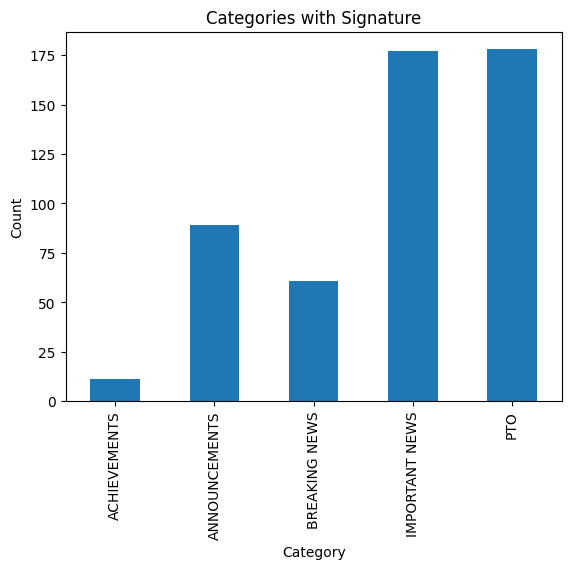

In [64]:
signature('L. Watkis (Assistant Principal)')

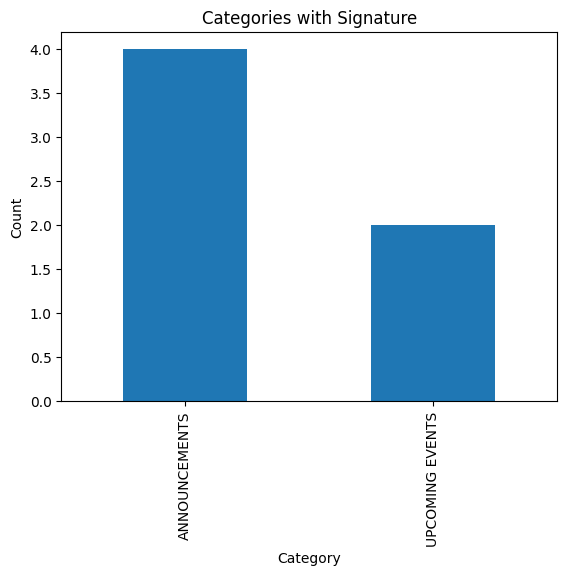

In [65]:
signature('Jaslynn Laurence')

In [66]:
def category_count(c):
    announcements = data[data['category'] == c]
    signature_counts = announcements['signature'].value_counts()
    plt.barh(signature_counts.index, signature_counts.values)
    plt.title('Number of Announcements by Signature')
    plt.xlabel('Number of Announcements')
    plt.ylabel('Signature')
    plt.show()

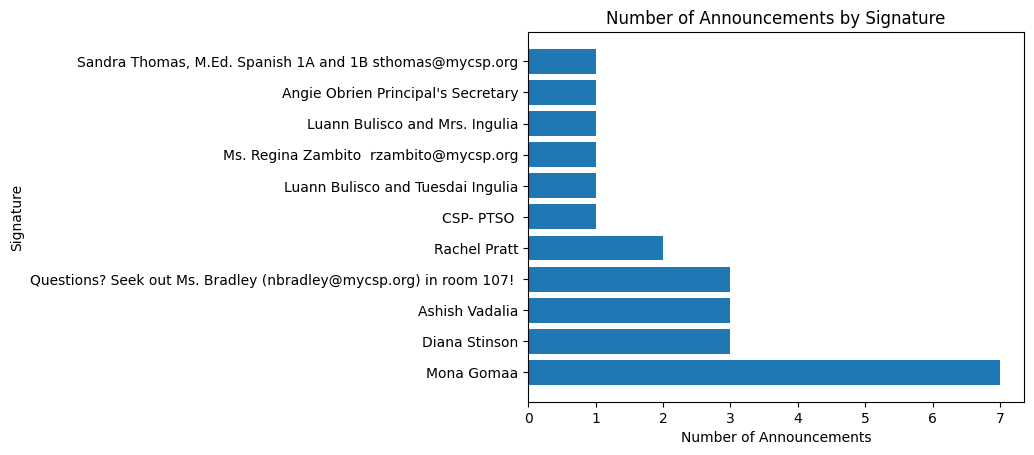

In [67]:
category_count('VOLUNTEERS NEEDED')

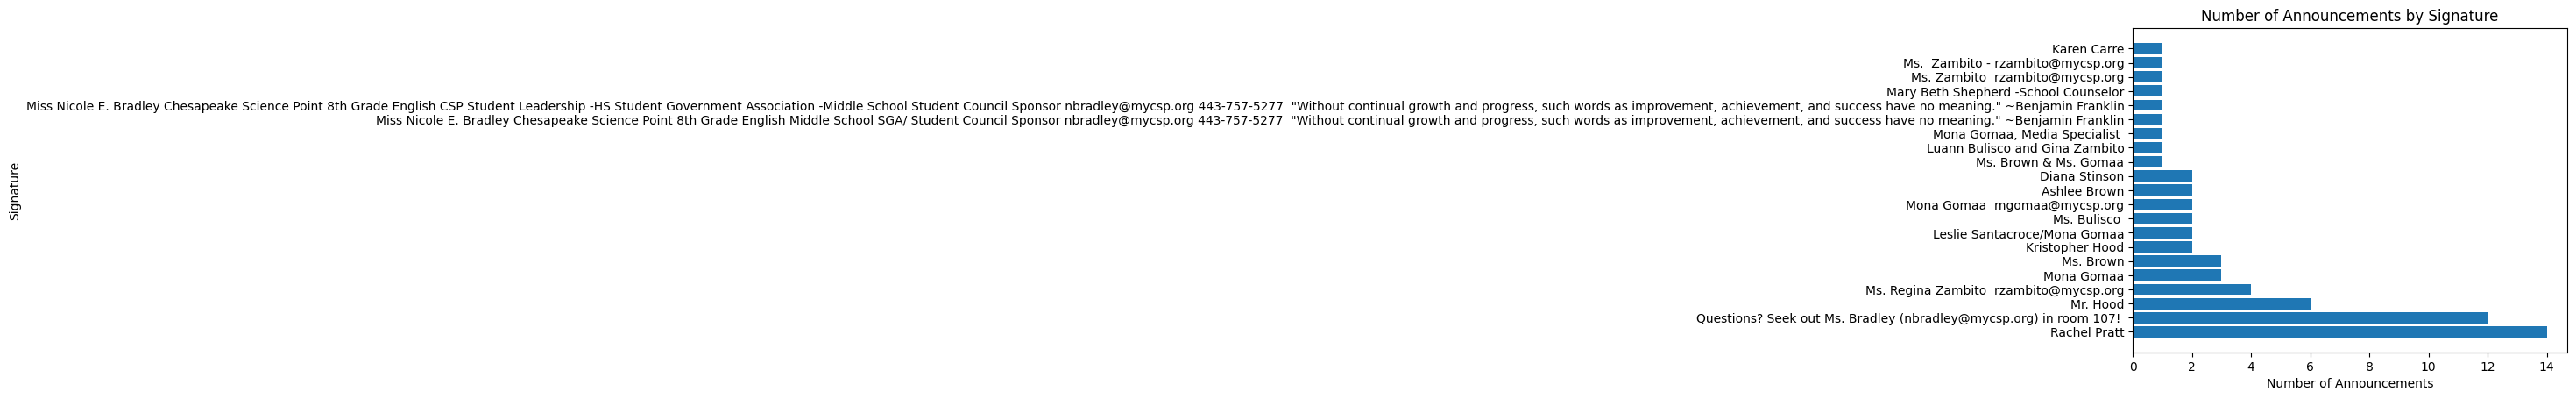

In [68]:
category_count('DONATIONS NEEDED')

In [7]:

data.dropna(inplace=True)

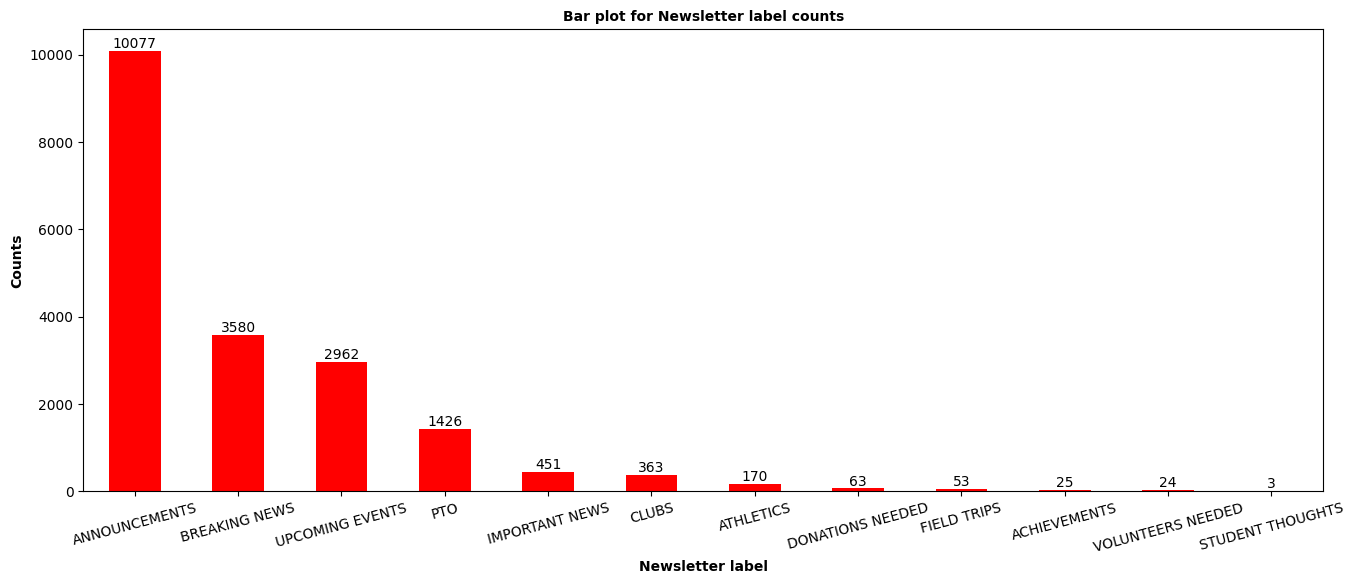

In [8]:
ax = data['category'].value_counts().plot(kind='bar',figsize=(16,6),color='red')
for c in ax.containers:
    
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='edge')
plt.ylabel('Counts',fontsize=10,fontweight='bold')  
plt.xlabel('Newsletter label',fontsize=10,fontweight='bold')  
plt.title('Bar plot for Newsletter label counts',fontsize=10,fontweight='bold') 
plt.xticks(rotation = 15) 
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.show()               

In [9]:
#since title body and signature columns are of string type 
#concatenating title, body and signature into one text column 
data['newsletter_text'] = data['title'] +' '+ data['body'] +' '+ data['signature']

#Text Processing

In [10]:
from tqdm import tqdm
def dictionary_words(text_list):
    corpus_tokens = []
    for i in tqdm(range(len(text_list))):
        text = text_list[i].lower() # converts the text to lower case
        text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)','',text) # replaces the emails with empty string
        #removes the URLs
        text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?    =%&:/~+#-]*[\w@?    =%&/~+#-])?','',text) 
        #text = re.sub('[^A-Za-z0-9]+', ' ', text)
        text = re.sub('[^A-Za-z]+', ' ', text)
        text = re.sub(' +',' ',text) # remove double or more spaces
        stop_words = open('stoplist.txt','r').read().split('\n')
        text = ' '.join([j for j in text.split(' ') if j not in stop_words]) #removing stop words
        text = ' '.join([j for j in text.split(' ') if len(j)>1]) #removing words of length 1
        tokens = text.split(' ') #creating word tokens list
        corpus_tokens = corpus_tokens + tokens
        
    d = dict(Counter(corpus_tokens))
    dictionary_words = [i for i,j in tqdm(d.items()) if j>1 and i in words.words()]
    return dictionary_words

In [11]:
dictionary_words = dictionary_words(data['newsletter_text'].tolist())

100%|██████████| 28674/28674 [28:54<00:00, 16.53it/s]


In [12]:
def preprocessing(text):
    text = text.lower() # converts the text to lower case
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)','',text) # replaces the emails with empty string
    #removes the URLs
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?    =%&:/~+#-]*[\w@?    =%&/~+#-])?','',text) 
    #text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub(' +',' ',text) # remove double or more spaces
    stop_words = open('stoplist.txt','r').read().split('\n')
    text = ' '.join([j for j in text.split(' ') if j not in stop_words]) #removing stop words
    text = ' '.join([j for j in text.split(' ') if len(j)>1 and j in dictionary_words]) #removing words of length 1
    
    return text   

In [13]:
from tqdm.notebook import tqdm
tqdm.pandas()
data['newsletter_text'] = data['newsletter_text'].progress_apply(lambda x: preprocessing(x))

  0%|          | 0/19197 [00:00<?, ?it/s]

In [14]:
#storing the text and category into new variable 
#and considering only these 2 columns for analysis
clean_data = data[['newsletter_text','category']]

In [15]:
#printing first 5 rows from clean_data
clean_data.head()

,newsletter_text,category
0,class upcoming holiday thanksgiving native col...,ANNOUNCEMENTS
1,winter break fun enjoy winter break complete a...,ANNOUNCEMENTS
2,operation gladly assist office am,ANNOUNCEMENTS
3,character education south continue various cha...,ANNOUNCEMENTS
4,globe couple classes opportunity connect class...,ANNOUNCEMENTS


In [16]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 7.6 MB/s eta 0:00:00


In [17]:
import nlpaug
import nlpaug.augmenter.word as naw

In [18]:
low_counts = list(clean_data['category'].value_counts()[4:].index)

In [19]:
import random as random

In [20]:
#augmenting the text data in order to tackle class imbalance
new_data = []
aug = naw.SynonymAug(aug_src='wordnet',aug_max=4)
for i in tqdm(low_counts):
    a = list(clean_data[clean_data['category']==i]['newsletter_text'])
    for j in range(200):
        r = random.randint(0,len(a)-1)
        aug_text = aug.augment(a[r],n=2)
        for k in aug_text:
            new_data.append((k,i))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  0%|          | 0/8 [00:00<?, ?it/s]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
#creating the dataframe for the augmneted texts
new_dataframe = pd.DataFrame(new_data,columns=['newsletter_text','category'])

In [22]:
#concatenating the augmented data with the old data
augmented_data = pd.concat([clean_data,new_dataframe],ignore_index=True)

In [23]:
print('No of data points before augmenting the data is',clean_data.shape[0])
print('No of data points after augmenting the data is',augmented_data.shape[0])

No of data points before augmenting the data is 19197
No of data points after augmenting the data is 22397


In [24]:
from wordcloud import WordCloud,STOPWORDS
text = ' '.join(i for i in augmented_data.newsletter_text)

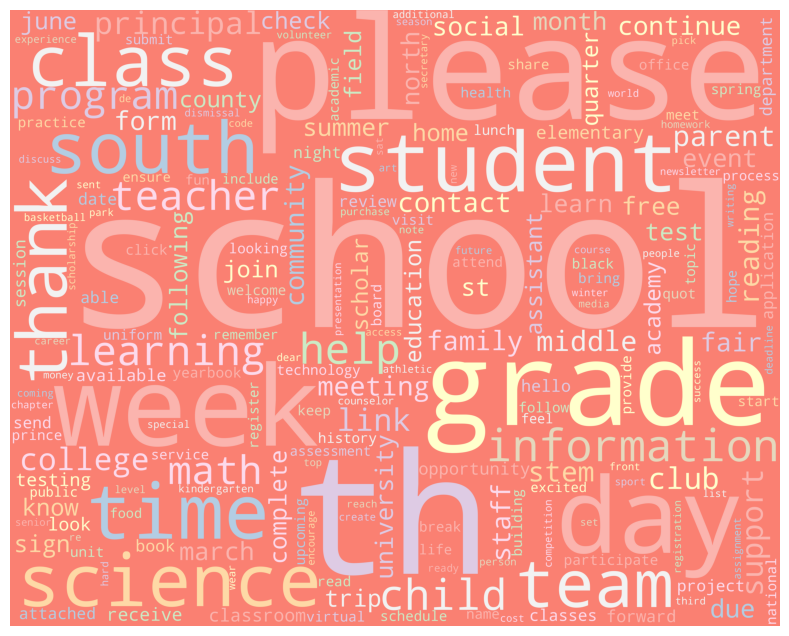

In [25]:
# Generate word cloud from newsletter text
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
        width=5000,
        height=4000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [26]:
Y = augmented_data['category'].values

In [27]:
X = augmented_data.drop(['category'],axis=1)

In [28]:
#splitting the data into train,cv and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [29]:
#encoding the target column
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder().fit(y_train.reshape(-1,1))
y_train_encoded = enc.transform(y_train.reshape(-1,1)).reshape(-1,)
y_cv_encoded    = enc.transform(y_cv.reshape(-1,1)).reshape(-1,)
y_test_encoded  = enc.transform(y_test.reshape(-1,1)).reshape(-1,)

In [30]:
#displays the encoded categories
enc.categories_[0]

array(['ACHIEVEMENTS', 'ANNOUNCEMENTS', 'ATHLETICS', 'BREAKING NEWS',
       'CLUBS', 'DONATIONS NEEDED', 'FIELD TRIPS', 'IMPORTANT NEWS',
       'PTO', 'STUDENT THOUGHTS', 'UPCOMING EVENTS', 'VOLUNTEERS NEEDED'],
      dtype=object)

## Encoding text using BOW

In [31]:
#Reference: https://medium.com/analytics-vidhya/nlp-text-encoding-a-beginners-guide-fa332d715854

from sklearn.feature_extraction.text import CountVectorizer

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print("*"*100)
vectorizer = CountVectorizer(min_df=20,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['newsletter_text'].values)

X_train_text_bow = vectorizer.transform(X_train['newsletter_text'].values)
X_cv_text_bow = vectorizer.transform(X_cv['newsletter_text'].values)
X_test_text_bow = vectorizer.transform(X_test['newsletter_text'].values)

print("After vectorizations")
print(X_train_text_bow.shape, y_train_encoded.shape)
print(X_cv_text_bow.shape, y_cv_encoded.shape)
print(X_test_text_bow.shape, y_test_encoded.shape)

(10053, 1) (10053,)
(4952, 1) (4952,)
(7392, 1) (7392,)
****************************************************************************************************
After vectorizations
(10053, 4696) (10053,)
(4952, 4696) (4952,)
(7392, 4696) (7392,)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report

In [33]:
def find_f1_score(model,x_train,x_cv,y_train,y_cv):
    y_train_pred = np.argmax(model.predict_proba(x_train),axis=1)
    y_cv_pred    = np.argmax(model.predict_proba(x_cv),axis=1)
    
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_cv    = f1_score(y_cv, y_cv_pred, average='macro')
    
    print('Train F1 Score is',f1_train)
    print('CV F1 Score is',f1_cv)
    
    print(100*'*')
    print('Train Report')
    print(classification_report(y_train, y_train_pred, target_names=enc.categories_[0]))
    print(100*'*')
    print('CV Report')
    print(classification_report(y_cv, y_cv_pred, target_names=enc.categories_[0]))

    return None 

#Model1 - Random Classifier

In [34]:
#Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_clf = RandomForestClassifier(class_weight='balanced')
params  ={'max_depth'       : [2,5,7,9,12,15],
         'n_estimators'     : [5,50,100,200,500,1000,2000]
          }
random_rf    = RandomizedSearchCV(rf_clf,param_distributions=params,verbose=2,cv=2).fit(X_train_text_bow,y_train_encoded)    
RF           = rf_clf.set_params(**random_rf.best_params_).fit(X_train_text_bow,y_train_encoded)
print(100*'*')
find_f1_score(RF,X_train_text_bow,X_cv_text_bow,y_train_encoded,y_cv_encoded)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=9, n_estimators=2000; total time=  11.5s
[CV] END .....................max_depth=9, n_estimators=2000; total time=  11.6s
[CV] END ....................max_depth=12, n_estimators=1000; total time=   6.7s
[CV] END ....................max_depth=12, n_estimators=1000; total time=   7.7s
[CV] END .....................max_depth=2, n_estimators=2000; total time=   6.8s
[CV] END .....................max_depth=2, n_estimators=2000; total time=   8.0s
[CV] END ......................max_depth=9, n_estimators=200; total time=   1.1s
[CV] END ......................max_depth=9, n_estimators=200; total time=   1.1s
[CV] END .....................max_depth=9, n_estimators=1000; total time=   6.2s
[CV] END .....................max_depth=9, n_est

#Model2 - XGB Classifier

In [35]:
#Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

xgb_clf = XGBClassifier()
params={'n_estimators'    : [5,50,100,150,200,300,500],
        'max_depth'       : [3,5,7,10,12],
        'colsample_bytree': [0.3,0.4,0.6,0.8]
        }       
random_xgb = RandomizedSearchCV(xgb_clf,param_distributions=params,verbose=2,cv=2).fit(X_train_text_bow,y_train_encoded)     
XGB        = xgb_clf.set_params(**random_xgb.best_params_).fit(X_train_text_bow,y_train_encoded)    
print(100*'*')
find_f1_score(XGB,X_train_text_bow,X_cv_text_bow,y_train_encoded, y_cv_encoded)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=  16.5s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=  12.5s
[CV] END colsample_bytree=0.4, max_depth=5, n_estimators=500; total time=  52.5s
[CV] END colsample_bytree=0.4, max_depth=5, n_estimators=500; total time=  52.3s
[CV] END colsample_bytree=0.6, max_depth=5, n_estimators=150; total time=  22.9s
[CV] END colsample_bytree=0.6, max_depth=5, n_estimators=150; total time=  23.8s
[CV] END .colsample_bytree=0.3, max_depth=10, n_estimators=5; total time=   0.8s
[CV] END .colsample_bytree=0.3, max_depth=10, n_estimators=5; total time=   0.8s
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=500; total time= 1.1min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=500; total time= 1.1min
[CV] END colsample_bytree=0.3, max_depth=12, n_estimators=150; total time=  29.9s
[CV] END colsample_bytree=0.3, max_depth=12, n_

In [36]:
#Test predictions 
#XGB Classifier performed better when compared to Random Forest Classifier
#and hence used for predictions on the test data.
y_test_pred = np.argmax(XGB.predict_proba(X_test_text_bow),axis=1)
f1_test     = f1_score(y_test_encoded, y_test_pred, average='macro')
print('F1 Test Score is',f1_test)

F1 Test Score is 0.814503154364212


#Random Checking for the Dataset

In [37]:
#Predictions on the random 10 data points in the test data
for i in range(10):
    r = random.randint(0,len(X_test)-1)
    text = list(X_test.values)[r][0]
    text = preprocessing(text)
    v = vectorizer.transform([text])
    pred_label = enc.categories_[0][np.argmax(XGB.predict_proba(v),axis=1)][0]
    act_label  = list(y_test)[r]
    print('Predicted label is',pred_label)
    print('Actual label is',act_label)
    print(100*'*')

Predicted label is CLUBS
Actual label is CLUBS
****************************************************************************************************
Predicted label is ANNOUNCEMENTS
Actual label is ANNOUNCEMENTS
****************************************************************************************************
Predicted label is IMPORTANT NEWS
Actual label is IMPORTANT NEWS
****************************************************************************************************
Predicted label is ANNOUNCEMENTS
Actual label is ANNOUNCEMENTS
****************************************************************************************************
Predicted label is ANNOUNCEMENTS
Actual label is BREAKING NEWS
****************************************************************************************************
Predicted label is ANNOUNCEMENTS
Actual label is ANNOUNCEMENTS
****************************************************************************************************
Predicted label is ANNOUNCEMEN

#Our own sample for the dataset

In [38]:
#predicting the label for the random text
sample = preprocessing('Congratulations, for your first achievement. Will send the guidlines for the next step soon.')
v = vectorizer.transform([sample])
pred_label = enc.categories_[0][np.argmax(XGB.predict_proba(v),axis=1)][0]
print('Predicted label is',pred_label)

Predicted label is ANNOUNCEMENTS


##CONCLUSION 

We've used two models Random Forest Classifier and XGBClassifier. We've noticed that XGBClassifier produced better results than 
Random Forest Classifier.